In [34]:
import json
import re
import stat
from collections import Counter, defaultdict
from pathlib import Path
from textwrap import dedent

import numpy as np
import pandas as pd

from bson import json_util
from bson.objectid import ObjectId
from mongoengine import connect, disconnect, DoesNotExist
from pycoshark.mongomodels import Commit, FileAction, File, Project, VCSSystem, Hunk, Issue, IssueSystem, Refactoring
from pycoshark.utils import create_mongodb_uri_string, java_filename_filter

# Comparison with line annotations in the Herbold et al. dataset

- S. Herbold, A. Trautsch, B. Ledel, A. Aghamohammadi, T. A. Ghaleb, K. K. Chahal, T. Bossenmaier, B. Nagaria, P. Makedonski, M. N. Ahmadabadi, K. Szabados, H. Spieker, M. Madeja, N. Hoy, V. Lenarduzzi, S. Wang, G. Rodríguez-Pérez, R. Colomo-Palacios, R. Verdecchia, P. Singh, Y. Qin, D. Chakroborti, W. Davis, V. Walunj, H. Wu, D. Marcilio, O. Alam, A. Aldaeej, I. Amit, B. Turhan, S. Eismann, A.-K. Wickert, I. Malavolta, M. Sulír, F. Fard, A. Z. Henley, S. Kourtzanidis, E. Tuzun, C. Treude, S. M. Shamasbi, I. Pashchenko, M. Wyrich,
J. Davis, A. Serebrenik, E. Albrecht, E. U. Aktas, D. Strüber, and J. Erbel, _“A fine-grained data set and analysis of tangling in bug fixing
commits,”_ Empirical Software Engineering, vol. 27, no. 6, p. 125, Nov. 2022<br>https://doi.org/10.1007/s10664-021-10083-5
- S. Herbold, A. Trautsch, B. Ledel, _“Large-Scale Manual Validation of Bugfixing Changes.”_ In Proceedings of the 17th International Conference on Mining Software Repositories (MSR '20). 2020. Association for Computing Machinery, New York, NY, USA, 611–614.<br> https://doi.org/10.1145/3379597.3387504

Replication package: 
- https://github.com/sherbold/replication-kit-2020-line-validation (last commit from Jul 30, 2021, 13 stars, 5 forks)
- https://github.com/smartshark/usage-examples (last commit from Aug 3, 2021, 6 starts 4 forks)

Release of Replication Kit (`replication-kit-2020-line-validation`) on May 6, 2022 - tagging<br>
https://github.com/sherbold/replication-kit-2020-line-validation/releases

Python data collection library for SmartSHARK: https://github.com/smartshark/pycoSHARK

Used in `Replication-Notebook.ipynb`:

```python
from pycoshark.mongomodels import Commit, FileAction, File, Project, VCSSystem, Hunk, Issue, IssueSystem, Refactoring
from pycoshark.utils import create_mongodb_uri_string, java_filename_filter
```

> **Contents of the repository \[with replication package]**
> - The `Replication-Notebook.ipynb` with all code required to reproduce our results from the raw data.
> - The data folder with the `hunk_labels.json` and the `leaderboard.json` file.
>     - The `hunk_labels.json` contains the relevant raw data for this study, i.e., the manual labels for the hunks.
>     - The `leaderboard.json` contains daily snapshots of the progress per user and per project.
> - The `figures/` folder with all result figures that are generated by the Replication-Notebook.

## Reading 'hunk_labels.json' for hunk_id's

We will be using `'hunk_labels.json'` file to limit to those anotations that were considered in Herbold et al. 2022 paper.

The MongoDB database that we will be using to augment the serialized data with information necessary to be able to compare with PatchScope (`diff-annotate`) annotations is `'smartshark_2_2'`, while `Replication-Notebook.ipyb` uses `'smartshark_1_2'`

At the time of writing this, the most recent version of SmartSHARK database is "SmartSHARK MongoDB Release 2.2"<br>
See https://smartshark.github.io/dbreleases/

In [2]:
# configuration local to the computer the notebook is being run on (!!!)
smartshark_dir = '/mnt/data/msr/smartshark_repositories/replication-kit-2020-line-validation'

In [3]:
hunk_data_file = 'data/hunk_labels.json'

In [4]:
# check that the path is correct
hunk_data_path = Path(smartshark_dir).joinpath(hunk_data_file)
assert hunk_data_path.is_file()

In [5]:
# read the data
with open(hunk_data_path, mode='r') as json_fp:
    smartshark_data = json.load(json_fp)

type(smartshark_data)

list

You can find detailed examination of the `'hunk_labels.json'` file schema in [_"Examining the format of SmartSHARK's 'hunk_labels.json'"_](./01-compare_annotations.ipynb#Examining-the-format-of-SmartSHARK's-'hunk_labels.json') seection of the [`01-compare_annotations.ipynb`](./01-compare_annotations.ipynb) Jupyter Notebook.

In [6]:
def extract_smartshark_hunk_ids(hunk_labels_data: list[dict]) -> list[str]:
    return [
        entry['hunk_id']['$oid'] for entry in hunk_labels_data
    ]

In [7]:
smartshark_hunk_ids = extract_smartshark_hunk_ids(smartshark_data)
smartshark_hunk_ids[:5]

['5a82f5aa912063217b88940a',
 '5a82f5aa912063217a8893ef',
 '5a82f5aa912063217b88940c',
 '5a82f5aa912063217a8893f1',
 '5a82f5aa912063217b88940e']

In [8]:
print(f"{len(smartshark_data)=}")
print(f"{len(smartshark_hunk_ids)=}")

len(smartshark_data)=31065
len(smartshark_hunk_ids)=31065


In [9]:
smartshark_hunk_ids_set = set(smartshark_hunk_ids)

In [10]:
%timeit '5a82f5aa912063217b88940c' in smartshark_hunk_ids
%timeit '5a82f5aa912063217b88940c' in smartshark_hunk_ids_set

44.8 ns ± 0.257 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
22.6 ns ± 0.239 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


## Load data from SmartSHARK MongoDB database

The code is based on [`Replication-Notebook.ipynb`](https://github.com/sherbold/replication-kit-2020-line-validation/blob/main/Replication-Notebook.ipynb) in [sherbold/replication-kit-2020-line-validation](https://github.com/sherbold/replication-kit-2020-line-validation) repository.

That code uses [mongoengine](https://pypi.org/project/mongoengine/) (an ORM-like layer on top of PyMongo, a Python Object-Document Mapper for working with MongoDB) and [pycoSHARK](https://pypi.org/project/pycoSHARK/) (basic MongoDB models for smartSHARK) packages.

We could have used only [PyMongo](https://pypi.org/project/pymongo/), but those packages mentioned above do offer nice conveniences.

```python
from pymongo import MongoClient

client = MongoClient(host, port)

smartshark_2_2_db = client['smartshark_2_2']
commits_table = smartshark_2_2_db['commit']
file_table = smartshark_2_2_db['file']
file_action_table = smartshark_2_2_db['file_action']
hunk_table = smartshark_2_2_db['hunk']
```

In [11]:
# configuration local to the computer the notebook is being run on (!!!)
credentials = {
    'db_user': '',
    'db_password': '',
    'db_hostname': 'localhost',
    'db_port': 37017,  # standard port is 27017
    'db_authentication_database': '',
    'db_ssl_enabled': False
}

database_name = 'smartshark_2_2'  # replication package for Herbold uses 'smartshark_1_2'

In [12]:
uri = create_mongodb_uri_string(**credentials)
uri

'mongodb://localhost:37017'

In [13]:
client = connect(database_name, host=uri, alias='default')
client

MongoClient(host=['localhost:37017'], document_class=dict, tz_aware=False, connect=True, read_preference=Primary())

Check that everything works correctly, by retrievieng example "hunk", with `$oid` of `'5a82f5ab912063217d88943b'`

In [14]:
Hunk.objects(pk='5a82f5ab912063217d88943b').first().to_mongo()

SON([('_id', ObjectId('5a82f5ab912063217d88943b')), ('file_action_id', ObjectId('58c898ebc03bb4351fbcad44')), ('new_start', 110), ('new_lines', 4), ('old_start', 109), ('old_lines', 2), ('content', '-        BufferedReader r = new BufferedReader(new InputStreamReader(URLHandlerRegistry.getDefault()\n-                .openStream(url)));\n+        URLHandler urlHandler = URLHandlerRegistry.getDefault();\n+        String charset = urlHandler.getURLInfo(url).getBodyCharset();\n+        InputStream contentStream = urlHandler.openStream(url);\n+        BufferedReader r = new BufferedReader(new InputStreamReader(contentStream, charset));\n'), ('lines_manual', {'sherbold': {'bugfix': [0, 1, 2, 3, 4, 5]}, 'riruk': {'refactoring': [0, 1, 4, 5], 'bugfix': [2, 3]}, 'aaghamohammadi': {'bugfix': [0, 1, 2, 3, 4, 5]}, 'omalam': {'refactoring': [0, 1, 4, 5], 'bugfix': [2, 3]}}), ('lines_verified', {'None': [0, 1, 4, 5], 'bugfix': [2, 3]}), ('uncorrected_lines_manual', {})])

In [15]:
h_id = Hunk.objects(pk='5a82f5ab912063217d88943b').first().id
h_id

ObjectId('5a82f5ab912063217d88943b')

In [16]:
str(h_id)

'5a82f5ab912063217d88943b'

In [17]:
Hunk.objects(pk='5a82f5ab912063217d88943b').first().lines_manual

{'sherbold': {'bugfix': [0, 1, 2, 3, 4, 5]},
 'riruk': {'refactoring': [0, 1, 4, 5], 'bugfix': [2, 3]},
 'aaghamohammadi': {'bugfix': [0, 1, 2, 3, 4, 5]},
 'omalam': {'refactoring': [0, 1, 4, 5], 'bugfix': [2, 3]}}

In [18]:
Hunk.objects(pk='5a82f5ab912063217d88943b').first().lines_verified

{'None': [0, 1, 4, 5], 'bugfix': [2, 3]}

In [19]:
Hunk.objects(pk='5a82f5ab912063217d88943b').first().content.split('\n')[:-1]

['-        BufferedReader r = new BufferedReader(new InputStreamReader(URLHandlerRegistry.getDefault()',
 '-                .openStream(url)));',
 '+        URLHandler urlHandler = URLHandlerRegistry.getDefault();',
 '+        String charset = urlHandler.getURLInfo(url).getBodyCharset();',
 '+        InputStream contentStream = urlHandler.openStream(url);',
 '+        BufferedReader r = new BufferedReader(new InputStreamReader(contentStream, charset));']

-----

Exploration for multi-group hunk

We need to find line number in file, in pre-image or post-image, accordingly.  Multi-group hunk represents the most difficult case.

In [20]:
hunk = Hunk.objects(pk='5b27c661eee553716977ddcb').first()

hunk_lines_data = {}
hunk_lines = hunk.content.split('\n')[:-1]  # remove trailing empty element, because '\n' is terminator
hunk_count_m = 0
hunk_count_p = 0
hunk_offsets_m = {}
hunk_offsets_p = {}
for i, line in enumerate(hunk_lines):
    line_type = line[:1]
    if line_type == '-':
        hunk_offsets_m[i] = hunk_count_m
        hunk_count_m += 1
    elif line_type == '+':
        hunk_offsets_p[i] = hunk_count_p
        hunk_count_p += 1
    elif line_type == ' ':
        hunk_count_m += 1
        hunk_count_p += 1
    else:
        pass

hunk_lines

['-   public static TokenNameFinderModel train(String languageCode, String type, ObjectStream<NameSample> samples, ',
 '-       byte[] generatorDescriptor, final Map<String, Object> resources, ',
 '+   public static TokenNameFinderModel train(String languageCode, String type, ObjectStream<NameSample> samples,',
 '+       byte[] generatorDescriptor, final Map<String, Object> resources,',
 '        int iterations, int cutoff) throws IOException {',
 '-     ',
 '+',
 '      // TODO: Pass in resource manager ...',
 '-     ',
 '+',
 '      AdaptiveFeatureGenerator featureGenerator = createFeatureGenerator(generatorDescriptor, resources);',
 '-     ',
 '+']

In [21]:
hunk_offsets_m

{0: 0, 1: 1, 5: 3, 8: 5, 11: 7}

In [22]:
[hunk_lines[off] for off in hunk_offsets_m.keys()]

['-   public static TokenNameFinderModel train(String languageCode, String type, ObjectStream<NameSample> samples, ',
 '-       byte[] generatorDescriptor, final Map<String, Object> resources, ',
 '-     ',
 '-     ',
 '-     ']

In [23]:
w = 50
for i, line in enumerate(hunk_lines):
    line_type = line[:1]
    l = "" if line_type == '+' else line
    r = "" if line_type == '-' else line
    
    ln = ""
    rn = ""
    if line_type == '-':
        if i in hunk_offsets_m:
            ln = "{n:2d}".format(n=hunk_offsets_m[i])
        else:
            ln = "??"
    if line_type == '+':
        if i in hunk_offsets_p:
            rn = "{n:2d}".format(n=hunk_offsets_p[i])
        else:
            rn = "??"
    if line_type == ' ':
        ln = "_"
        rn = "_"
    
    print(f"{i:2d} | {ln:>2s}:{l:<{w}.{w}s} | {rn:>2s}:{r:<{w}.{w}s}")

 0 |  0:-   public static TokenNameFinderModel train(Strin |   :                                                  
 1 |  1:-       byte[] generatorDescriptor, final Map<Stri |   :                                                  
 2 |   :                                                   |  0:+   public static TokenNameFinderModel train(Strin
 3 |   :                                                   |  1:+       byte[] generatorDescriptor, final Map<Stri
 4 |  _:        int iterations, int cutoff) throws IOExcep |  _:        int iterations, int cutoff) throws IOExcep
 5 |  3:-                                                  |   :                                                  
 6 |   :                                                   |  3:+                                                 
 7 |  _:      // TODO: Pass in resource manager ...        |  _:      // TODO: Pass in resource manager ...       
 8 |  5:-                                                  |   :                

In [24]:
w = 50
for i, line in enumerate(hunk_lines):
    line_type = line[:1]
    l = "" if line_type == '+' else line+'⋅'
    r = "" if line_type == '-' else line+'⋅'
    
    ln = ""
    rn = ""
    if line_type == '-':
        if i in hunk_offsets_m:
            ln = "{n:3d}".format(n=hunk_offsets_m[i] + hunk.old_start)
        else:
            ln = "??"
    if line_type == '+':
        if i in hunk_offsets_p:
            rn = "{n:3d}".format(n=hunk_offsets_p[i] + hunk.new_start)
        else:
            rn = "??"
    if line_type == ' ':
        ln = "___"
        rn = "___"
    
    print(f"{i:2d} | {ln:>3s}:{l:<{w}.{w}s} | {rn:>3s}:{r:<{w}.{w}s}")

 0 | 450:-   public static TokenNameFinderModel train(Strin |    :                                                  
 1 | 451:-       byte[] generatorDescriptor, final Map<Stri |    :                                                  
 2 |    :                                                   | 450:+   public static TokenNameFinderModel train(Strin
 3 |    :                                                   | 451:+       byte[] generatorDescriptor, final Map<Stri
 4 | ___:        int iterations, int cutoff) throws IOExcep | ___:        int iterations, int cutoff) throws IOExcep
 5 | 453:-     ⋅                                            |    :                                                  
 6 |    :                                                   | 453:+⋅                                                
 7 | ___:      // TODO: Pass in resource manager ...⋅       | ___:      // TODO: Pass in resource manager ...⋅      
 8 | 455:-     ⋅                                            |   

The above is not _quite_ the side by side diff view, but close enough that one can check if the code for computing line numbers (line number in pre-image for '-' lines, line number in post-image for '+' lines) produces correct results.

Compare with side-by-side diff in GitHub:<br>
https://github.com/apache/opennlp/commit/4496b1e746451527bfb05e7ea48358c4ae509e1b

End of exploration

-----

Code based on the code in  `Replication-Notebook.ipynb` in sherbold/replication-kit-2020-line-validation

In [25]:
# switch to False if you want to avoid queruing the MongoDB database
use_mongodb = True

In [26]:
# set to true for debugging issues
is_test = False

Running with `use_mongodb` set to `True` takes around 8min 15s
- running without `is_test` set to `False` takes 4.5 minutes to only load list of hunks

In [27]:
%%time

# NOTE that using %%time inhibits debugging errors

if use_mongodb:
    smartshark_records = []
    hunks_extra = []
    hunks_miss = []
    hunks_multi_issue = []

    if is_test:
        # for faster testing, run process for single hunk
        hunks = [Hunk.objects(pk='5b27c661eee553716977ddcb').first()]
    else:
        # cache hunks locally to avoid timeouts
        hunks = [h for h in Hunk.objects(lines_manual__exists=True)]

    for hunk in hunks:
        hunk_id = str(hunk.id)
        
        if hunk_id not in smartshark_hunk_ids_set:
            hunks_extra.append(hunk_id)
            continue
        if len(hunk.lines_manual) <= 3:
            hunks_miss.append(hunk_id)
            continue

        fa = FileAction.objects(id=hunk.file_action_id).get()
        file = File.objects(id=fa.file_id).get()
        commit = Commit.objects(id=fa.commit_id).only('revision_hash', 'fixed_issue_ids', 'vcs_system_id').get()
        vcs = VCSSystem.objects(id=commit.vcs_system_id).get()
        project = Project.objects(id=vcs.project_id).get()
        
        external_id = None
        num_fixed_bugs = 0
        for issue in Issue.objects(id__in=commit.fixed_issue_ids):
            if issue.issue_type_verified is not None and issue.issue_type_verified.lower() == 'bug':
                num_fixed_bugs += 1
                external_id = issue.external_id

        if num_fixed_bugs != 1:
            hunks_multi_issue.append({'hunk_id': hunk_id, 'num_fixed_bugs': num_fixed_bugs})
            continue

        hunk_info = {
            'project': project.name,
            'repository_url': vcs.url,
            'issue_id': issue.external_id,
            'revision_hash':commit.revision_hash,
            'file': file.path,
            'hunk_id': hunk_id,
            'old_start': hunk.old_start,
            'old_lines': hunk.old_lines,
            'new_start': hunk.new_start,
            'new_lines': hunk.new_lines,
        }

        # in chunk of changes/change group, removed lines/old lines ('-') always precede added lines/new lines ('+')
        # but "hunk" in SmartSHARK data does not need to consist of single change group,
        # see hunk with id '5b27c661eee553716977ddcb' for the counter example
        
        hunk_lines_data = {}
        
        hunk_lines = hunk.content.split('\n')[:-1]  # remove trailing empty element, because '\n' is terminator
        hunk_count_m = 0
        hunk_count_p = 0
        hunk_offsets_m = {}
        hunk_offsets_p = {}
        for i, line in enumerate(hunk_lines):
            line_type = line[:1]
            if line_type == '-':
                hunk_offsets_m[i] = hunk_count_m
                hunk_count_m += 1
            elif line_type == '+':
                hunk_offsets_p[i] = hunk_count_p
                hunk_count_p += 1
            elif line_type == ' ':
                hunk_count_m += 1
                hunk_count_p += 1
            else:
                pass

        for hunk_line_no, line in enumerate(hunk_lines):
            pm = line[:1]
            hunk_lines_data[hunk_line_no] = {
                'in_hunk_idx': hunk_line_no,
                'pm': pm,
                'diff_line': line,
            }
            if pm == '-':
                if hunk_line_no in hunk_offsets_m:
                    hunk_lines_data[hunk_line_no]['file_line'] = hunk.old_start + hunk_offsets_m[hunk_line_no]
                else:
                    # possibly mark with 'file_line' set to -1
                    pass  # mark as N/A, should not happen
            if pm == '+':
                if hunk_line_no in hunk_offsets_p:
                    hunk_lines_data[hunk_line_no]['file_line'] = hunk.new_start + hunk_offsets_p[hunk_line_no]
                else:
                    # possibly mark with 'file_line' set to -1
                    pass  # mark as N/A, should not happen

        for label, lines_list in hunk.lines_verified.items():
            for hunk_line_no in lines_list:
                hunk_lines_data[hunk_line_no]['lines_verified'] = label

        # saving in "wide" format, witn N/A values
        for user_name, user_data in hunk.lines_manual.items():
            for label, lines_list in user_data.items():
                for hunk_line_no in lines_list:
                    hunk_lines_data[hunk_line_no][f'user_{user_name}'] = label

        for lines_data in hunk_lines_data.values():
            # with modern Python, we could use `.append(hunk_info | lines_data)`
            smartshark_records.append({
                **hunk_info,
                **lines_data,
            })

    print(f"{len(smartshark_hunk_ids)=} (present in 'hunk_labels.json')")
    print(f"{len(hunks_extra)=} (outside 'smartshark_1_2' used in Herbold et al., and present in 'hunk_labels.json')")
    print(f"{len(hunks_miss)=} (with 3 or less annotators/users)")
    print(f"{len(hunks_multi_issue)=} (commits that link to multiple bugs)")
    print(f"{len(smartshark_records)=} lines (results of parsing)")

else:
    print(f"skipping (use_mongodb=={use_mongodb})")

print("")  # to separate printing of %%time output

len(smartshark_hunk_ids)=31065 (present in 'hunk_labels.json')
len(hunks_extra)=5813357 (outside 'smartshark_1_2' used in Herbold et al., and present in 'hunk_labels.json')
len(hunks_miss)=0 (with 3 or less annotators/users)
len(hunks_multi_issue)=0 (commits that link to multiple bugs)
len(smartshark_records)=296348 lines (results of parsing)

CPU times: user 5min 58s, sys: 18 s, total: 6min 16s
Wall time: 7min 15s


In [28]:
smartshark_records[:2]

[{'project': 'ant-ivy',
  'repository_url': 'https://github.com/apache/ant-ivy',
  'issue_id': 'IVY-1391',
  'revision_hash': 'fdb75911387f77912c37dcee0af4a2f2e0977f3c',
  'file': 'test/java/org/apache/ivy/ant/IvyPublishTest.java',
  'hunk_id': '5a82f5f7912063217d88ef35',
  'old_start': 249,
  'old_lines': 0,
  'new_start': 250,
  'new_lines': 49,
  'in_hunk_idx': 0,
  'pm': '+',
  'diff_line': '+    ',
  'file_line': 250,
  'lines_verified': 'test_doc_whitespace',
  'user_aaghamohammadi': 'whitespace',
  'user_KKC': 'test',
  'user_uGAVaWPHVmMZKjBZ': 'test',
  'user_LDlnwznmYPWdNVSA': 'whitespace'},
 {'project': 'ant-ivy',
  'repository_url': 'https://github.com/apache/ant-ivy',
  'issue_id': 'IVY-1391',
  'revision_hash': 'fdb75911387f77912c37dcee0af4a2f2e0977f3c',
  'file': 'test/java/org/apache/ivy/ant/IvyPublishTest.java',
  'hunk_id': '5a82f5f7912063217d88ef35',
  'old_start': 249,
  'old_lines': 0,
  'new_start': 250,
  'new_lines': 49,
  'in_hunk_idx': 1,
  'pm': '+',
  'diff_l

In [29]:
smartshark_records[-2:]

[{'project': 'commons-scxml',
  'repository_url': 'https://github.com/apache/commons-scxml.git',
  'issue_id': 'SCXML-14',
  'revision_hash': '2bff4be4f58a70359154b9b5752074586ff3c852',
  'file': 'src/test/java/org/apache/commons/scxml/SCXMLExecutorTest.java',
  'hunk_id': '5bef252783ad2f56e82c95d1',
  'old_start': 125,
  'old_lines': 0,
  'new_start': 128,
  'new_lines': 21,
  'in_hunk_idx': 19,
  'pm': '+',
  'diff_line': '+    }',
  'file_line': 147,
  'lines_verified': 'test',
  'user_aaghamohammadi': 'test',
  'user_melkor54248': 'test',
  'user_NGKRdSgaxGAtmSqP': 'test',
  'user_bossenti': 'test'},
 {'project': 'commons-scxml',
  'repository_url': 'https://github.com/apache/commons-scxml.git',
  'issue_id': 'SCXML-14',
  'revision_hash': '2bff4be4f58a70359154b9b5752074586ff3c852',
  'file': 'src/test/java/org/apache/commons/scxml/SCXMLExecutorTest.java',
  'hunk_id': '5bef252783ad2f56e82c95d1',
  'old_start': 125,
  'old_lines': 0,
  'new_start': 128,
  'new_lines': 21,
  'in_hun

In [30]:
if use_mongodb:
    # store to disk
    with open('../../herbold_line_labels.json', 'w') as file:
        file.write(json_util.dumps(smartshark_records))

The `'herbold_line_labels.json'` file size is 174M.

```console
$ file herbold_line_labels.json
herbold_line_labels.json: ASCII text, with very long lines (65536), with no line terminators
```

In [31]:
if use_mongodb:
    # create dataframe
    smartshark_df = pd.DataFrame.from_records(smartshark_records)

In [32]:
if use_mongodb:
    # and store to disk
    # NOTE: using .to_parquet() of .to_feather() requires either the fastparquet or pyarrow library
    # NOTE: using .to_hdf() requires pytables library
    # NOTE: reading from pickle requires ABI compatibility
    smartshark_df.to_csv('../../herbold_line_labels.csv', index=False)

The `'herbold_line_labels.pickle'` file size would be 203M<br>
The `'herbold_line_labels.csv'` file size is 104M

In [37]:
# last line of this subsection
disconnect()

## Load serialized SmartSHARK data from CSV

If you skipped the extraction of data from the MongoDB, you can just load the data from the provided CSV file.

In [38]:
if not use_mongodb:
    # without `low_memory=False` we get DtypeWarning about columns having mixed types
    smartshark_df = pd.read_csv('../../herbold_line_labels.csv', low_memory=False)

## The structure of the SmartSHARK data

In [39]:
smartshark_df.columns

Index(['project', 'repository_url', 'issue_id', 'revision_hash', 'file',
       'hunk_id', 'old_start', 'old_lines', 'new_start', 'new_lines',
       'in_hunk_idx', 'pm', 'diff_line', 'file_line', 'lines_verified',
       'user_aaghamohammadi', 'user_KKC', 'user_uGAVaWPHVmMZKjBZ',
       'user_LDlnwznmYPWdNVSA', 'user_riruk', 'user_omalam', 'user_sherbold',
       'user_vijaybw', 'user_evidencebp', 'user_atrautsch', 'user_davisjam',
       'user_Jiong', 'user_kaka727', 'user_dvmarcilio', 'user_bledel',
       'user_CUE', 'user_bossenti', 'user_nikoHu', 'user_simin',
       'user_grodrig', 'user_JjGyDTFSqlCnXIzk', 'user_NGKRdSgaxGAtmSqP',
       'user_melkor54248', 'user_TeeKea', 'user_rcolomo', 'user_perfwxc',
       'user_aserebrenik', 'user_lancelot', 'user_ladybug', 'user_ealbrec',
       'user_matin', 'user_ivanomalavolta', 'user_ppp23', 'user_psingh',
       'user_Pyrrhon', 'user_LastButNotLeast', 'user_ctreude', 'user_azhenley',
       'user_sulir', 'user_turtle', 'user_Badger', 

In [40]:
smartshark_col_user = [col for col in smartshark_df.columns if col.startswith('user_')]
smartshark_col_rest = [col for col in smartshark_df.columns if not col.startswith('user_')]

smartshark_col_rest

['project',
 'repository_url',
 'issue_id',
 'revision_hash',
 'file',
 'hunk_id',
 'old_start',
 'old_lines',
 'new_start',
 'new_lines',
 'in_hunk_idx',
 'pm',
 'diff_line',
 'file_line',
 'lines_verified']

In [41]:
smartshark_df.shape

(296348, 79)

In [42]:
smartshark_df[smartshark_col_rest].dtypes

project            object
repository_url     object
issue_id           object
revision_hash      object
file               object
hunk_id            object
old_start           int64
old_lines           int64
new_start           int64
new_lines           int64
in_hunk_idx         int64
pm                 object
diff_line          object
file_line         float64
lines_verified     object
dtype: object

### Filter out lines without 'file_line'

The fact that dtype for 'file_line' column is float64 and not int64 suggest that there are some N/A values there.

Let's examine this case.

In [43]:
smartshark_df['file_line'].isna().sum()

np.int64(5536)

In [44]:
smartshark_df[smartshark_df['file_line'].isna()][smartshark_col_rest]

,project,repository_url,issue_id,revision_hash,file,hunk_id,old_start,old_lines,new_start,new_lines,in_hunk_idx,pm,diff_line,file_line,lines_verified
184,ant-ivy,https://github.com/apache/ant-ivy,IVY-716,66310f553103e515ab41aa573aaf2e4101efa635,src/java/org/apache/ivy/ant/IvyRepositoryRepor...,5a82f5bd912063217a88a212,90,12,93,18,15,,for (int i = 0; i < mrids.length;...,NaN,NaN
191,ant-ivy,https://github.com/apache/ant-ivy,IVY-716,66310f553103e515ab41aa573aaf2e4101efa635,src/java/org/apache/ivy/ant/IvyRepositoryRepor...,5a82f5bd912063217a88a212,90,12,93,18,22,,},NaN,NaN
224,ant-ivy,https://github.com/apache/ant-ivy,IVY-1391,fdb75911387f77912c37dcee0af4a2f2e0977f3c,test/java/org/apache/ivy/ant/extends/child1/iv...,5a82f5f7912063217d88ef39,0,0,1,27,27,\,\ No newline at end of file,NaN,NaN
380,ant-ivy,https://github.com/apache/ant-ivy,IVY-1206,84fd1dd099e6d44cdc5a2d6718197022f257dce9,test/java/org/apache/ivy/ant/ivy-extends-extra...,5a82f5ac912063217a889507,0,0,1,27,27,\,\ No newline at end of file,NaN,NaN
413,ant-ivy,https://github.com/apache/ant-ivy,IVY-716,66310f553103e515ab41aa573aaf2e4101efa635,src/java/org/apache/ivy/core/install/InstallEn...,5a82f5bd912063217a88a216,106,6,106,5,2,,,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296032,commons-scxml,https://github.com/apache/commons-scxml.git,SCXML-21,db1e09c815847d5d11d063bb925af61e1784ac40,src/main/java/org/apache/commons/scxml/model/S...,5bef252783ad2f56ef2c9673,307,11,291,65,36,,long wait = 0L;,NaN,NaN
296050,commons-scxml,https://github.com/apache/commons-scxml.git,SCXML-21,db1e09c815847d5d11d063bb925af61e1784ac40,src/main/java/org/apache/commons/scxml/model/S...,5bef252783ad2f56ef2c9673,307,11,291,65,54,,try {,NaN,NaN
296053,commons-scxml,https://github.com/apache/commons-scxml.git,SCXML-21,db1e09c815847d5d11d063bb925af61e1784ac40,src/main/java/org/apache/commons/scxml/model/S...,5bef252783ad2f56ef2c9673,307,11,291,65,57,,} catch (NumberFormatException nf...,NaN,NaN
296058,commons-scxml,https://github.com/apache/commons-scxml.git,SCXML-21,db1e09c815847d5d11d063bb925af61e1784ac40,src/main/java/org/apache/commons/scxml/model/S...,5bef252783ad2f56ef2c9673,307,11,291,65,62,,},NaN,NaN


In [45]:
smartshark_df[smartshark_df['file_line'].isna()]['pm'].value_counts()

pm
     5363
\     173
Name: count, dtype: int64

In [46]:
smartshark_df[smartshark_df['file_line'].notna()]['pm'].value_counts()

pm
+    222624
-     68188
Name: count, dtype: int64

In [47]:
smartshark_df[smartshark_df['file_line'].isna()]['lines_verified']

184       NaN
191       NaN
224       NaN
380       NaN
413       NaN
         ... 
296032    NaN
296050    NaN
296053    NaN
296058    NaN
296061    NaN
Name: lines_verified, Length: 5536, dtype: object

In [48]:
smartshark_df[smartshark_df['file_line'].notna()]['lines_verified'].value_counts()

lines_verified
test                   115073
bugfix                  73056
documentation           40644
None                    25888
no_bugfix               13076
whitespace              11935
refactoring              5297
test_doc_whitespace      4475
unrelated                1361
Name: count, dtype: int64

It turns out, that all cases without 'file_line' are non-changed lines that have been (accidentally?) caught.

It also turns out that all those cases did not pass the 'lines_verified' test.

So let's drop them.

In [49]:
smartshark_df_sel = smartshark_df[smartshark_df['file_line'].notna()]

In [50]:
print(f"We are left with {smartshark_df_sel.shape[0]}/{smartshark_df.shape[0]} = "
      f"{smartshark_df_sel.shape[0]/smartshark_df.shape[0]} elements")

We are left with 290812/296348 = 0.9813192597891668 elements


In [51]:
smartshark_mask_1 = smartshark_df['file_line'].notna()
smartshark_mask_1.sum()

np.int64(290812)

### Consensus in SmartSHARK

In [52]:
smartshark_col_user

['user_aaghamohammadi',
 'user_KKC',
 'user_uGAVaWPHVmMZKjBZ',
 'user_LDlnwznmYPWdNVSA',
 'user_riruk',
 'user_omalam',
 'user_sherbold',
 'user_vijaybw',
 'user_evidencebp',
 'user_atrautsch',
 'user_davisjam',
 'user_Jiong',
 'user_kaka727',
 'user_dvmarcilio',
 'user_bledel',
 'user_CUE',
 'user_bossenti',
 'user_nikoHu',
 'user_simin',
 'user_grodrig',
 'user_JjGyDTFSqlCnXIzk',
 'user_NGKRdSgaxGAtmSqP',
 'user_melkor54248',
 'user_TeeKea',
 'user_rcolomo',
 'user_perfwxc',
 'user_aserebrenik',
 'user_lancelot',
 'user_ladybug',
 'user_ealbrec',
 'user_matin',
 'user_ivanomalavolta',
 'user_ppp23',
 'user_psingh',
 'user_Pyrrhon',
 'user_LastButNotLeast',
 'user_ctreude',
 'user_azhenley',
 'user_sulir',
 'user_turtle',
 'user_Badger',
 'user_ethemutku',
 'user_aarvQeMWXRSETYJu',
 'user_ekrisza',
 'user_danielstrueber',
 'user_Ruuku',
 'user_erbel',
 'user_Vale',
 'user_turhanb',
 'user_joydeba',
 'user_matt',
 'user_deepblue',
 'user_tAkmSjmapQPEZrVe',
 'user_ap',
 'user_Apollo',
 

In [53]:
def most_common_value(row):
    ret = Counter()
    val = None
    cnt = 0
    for u_col in smartshark_col_user:
        u_val = row[u_col]
        if not pd.isnull(u_val):
            ret[u_val] += 1
            val = u_val
            cnt += 1

    if cnt > 0:
        return Counter(ret).most_common(1)[0][0]
    else:
        return pd.NA

In [54]:
def n_reviewers(row):
    ret = 0
    for u_col in smartshark_col_user:
        u_val = row[u_col]
        if not pd.isnull(u_val):
            ret += 1

    return ret

In [55]:
def most_common_count(row):
    ret = Counter()
    val = None
    cnt = 0
    for u_col in smartshark_col_user:
        u_val = row[u_col]
        if not pd.isnull(u_val):
            ret[u_val] += 1
            val = u_val
            cnt += 1

    if cnt > 0:
        return Counter(ret).most_common(1)[0][1]
    else:
        return np.nan

In [56]:
row = smartshark_df.iloc[0]
row

project                                                    ant-ivy
repository_url                   https://github.com/apache/ant-ivy
issue_id                                                  IVY-1391
revision_hash             fdb75911387f77912c37dcee0af4a2f2e0977f3c
file              test/java/org/apache/ivy/ant/IvyPublishTest.java
                                        ...                       
user_JG                                                        NaN
user_yyh                                                       NaN
user_LuCH                                                      NaN
user_LeBron                                                    NaN
user_Mohammad                                                  NaN
Name: 0, Length: 79, dtype: object

In [57]:
row[smartshark_col_user].dropna()

user_aaghamohammadi      whitespace
user_KKC                       test
user_uGAVaWPHVmMZKjBZ          test
user_LDlnwznmYPWdNVSA    whitespace
Name: 0, dtype: object

In [58]:
most_common_value(row)

'whitespace'

In [59]:
n_reviewers(row)

4

In [60]:
most_common_count(row)

2

Test for row without 'file_line'

In [61]:
row_na = smartshark_df.iloc[296061]
row_na

project                                               commons-scxml
repository_url          https://github.com/apache/commons-scxml.git
issue_id                                                   SCXML-21
revision_hash              db1e09c815847d5d11d063bb925af61e1784ac40
file              src/main/java/org/apache/commons/scxml/model/S...
                                        ...                        
user_JG                                                         NaN
user_yyh                                                        NaN
user_LuCH                                                       NaN
user_LeBron                                                     NaN
user_Mohammad                                                   NaN
Name: 296061, Length: 79, dtype: object

In [62]:
row_na[smartshark_col_user].dropna()

Series([], Name: 296061, dtype: object)

In [63]:
most_common_value(row_na)

<NA>

In [64]:
n_reviewers(row_na)

0

In [65]:
most_common_count(row_na)

nan

In [66]:
pd.NA

<NA>

In [67]:
np.nan

nan

This code is not optimized, and takes around 1min 34s to execute.

In [68]:
%%time

# this could be done in  single step, I think, by returning list or pd.Series

smartshark_df['most_common'] = pd.DataFrame(smartshark_df.apply(most_common_value, axis=1))
smartshark_df['n_reviewers'] = pd.DataFrame(smartshark_df.apply(n_reviewers, axis=1))
smartshark_df['common_count'] = pd.DataFrame(smartshark_df.apply(most_common_count, axis=1))

smartshark_df.columns

CPU times: user 1min 27s, sys: 357 ms, total: 1min 27s
Wall time: 1min 27s


Index(['project', 'repository_url', 'issue_id', 'revision_hash', 'file',
       'hunk_id', 'old_start', 'old_lines', 'new_start', 'new_lines',
       'in_hunk_idx', 'pm', 'diff_line', 'file_line', 'lines_verified',
       'user_aaghamohammadi', 'user_KKC', 'user_uGAVaWPHVmMZKjBZ',
       'user_LDlnwznmYPWdNVSA', 'user_riruk', 'user_omalam', 'user_sherbold',
       'user_vijaybw', 'user_evidencebp', 'user_atrautsch', 'user_davisjam',
       'user_Jiong', 'user_kaka727', 'user_dvmarcilio', 'user_bledel',
       'user_CUE', 'user_bossenti', 'user_nikoHu', 'user_simin',
       'user_grodrig', 'user_JjGyDTFSqlCnXIzk', 'user_NGKRdSgaxGAtmSqP',
       'user_melkor54248', 'user_TeeKea', 'user_rcolomo', 'user_perfwxc',
       'user_aserebrenik', 'user_lancelot', 'user_ladybug', 'user_ealbrec',
       'user_matin', 'user_ivanomalavolta', 'user_ppp23', 'user_psingh',
       'user_Pyrrhon', 'user_LastButNotLeast', 'user_ctreude', 'user_azhenley',
       'user_sulir', 'user_turtle', 'user_Badger', 

From the Herbold et al. 2022 paper

> Each commit was shown to four participants. Consensus is achieved if at least three participants agree on the same label. If this is not the case, no consensus for the line is achieved, i.e., the participants could not clearly identify which type of change a line is.

Analyze values in just generated columns: 'most_common', 'n_reviewers', and 'common_count'

In [69]:
smartshark_df['n_reviewers'].value_counts()

n_reviewers
4     290572
0       5543
43       219
64        14
Name: count, dtype: int64

In [70]:
smartshark_df['common_count'].value_counts()

common_count
4.0     172544
3.0      74589
2.0      42046
1.0       1393
40.0        90
39.0        40
42.0        31
41.0        31
58.0         7
38.0         5
26.0         5
36.0         4
43.0         4
57.0         3
61.0         2
31.0         2
37.0         2
54.0         1
52.0         1
33.0         1
22.0         1
32.0         1
27.0         1
30.0         1
Name: count, dtype: int64

In [71]:
smartshark_df['most_common'].value_counts()

most_common
test             121370
bugfix            82484
documentation     49381
whitespace        18552
unrelated          9656
refactoring        9362
Name: count, dtype: int64

Compute consensus according to the definition in Herbold et al. 2022 paper: 3+ anotators agree

In [72]:
smartshark_df['has_consensus'] = smartshark_df['common_count'] >= 3
smartshark_df['has_consensus'].value_counts()

has_consensus
True     247366
False     48982
Name: count, dtype: int64

In [73]:
smartshark_df['has_consensus'].value_counts()/smartshark_df.shape[0]

has_consensus
True     0.834715
False    0.165285
Name: count, dtype: float64

Let's filter out elements without consensus (next filter)

In [74]:
smartshark_mask_2 = smartshark_df['has_consensus']
smartshark_mask_2.sum()

np.int64(247366)

In [75]:
smartshark_mask = smartshark_mask_1 & smartshark_mask_2
smartshark_mask.sum()

np.int64(247366)

In [76]:
smartshark_df_sel = smartshark_df[smartshark_mask]
smartshark_df_sel.shape

(247366, 83)

In [77]:
print(f"We are left with {smartshark_df_sel.shape[0]}/{smartshark_df.shape[0]} = "
      f"{smartshark_df_sel.shape[0]/smartshark_df.shape[0]} elements")

We are left with 247366/296348 = 0.834714592303643 elements


In [78]:
smartshark_col_user = [col for col in smartshark_df.columns if col.startswith('user_')]
smartshark_col_rest = [col for col in smartshark_df.columns if not col.startswith('user_')]

smartshark_col_rest

['project',
 'repository_url',
 'issue_id',
 'revision_hash',
 'file',
 'hunk_id',
 'old_start',
 'old_lines',
 'new_start',
 'new_lines',
 'in_hunk_idx',
 'pm',
 'diff_line',
 'file_line',
 'lines_verified',
 'most_common',
 'n_reviewers',
 'common_count',
 'has_consensus']

## DataFrame from diff-annotator on SmartSHARK repos

First step is to generate annotation data

### Commits for/per repo

Find all the commit, and which repos they belong to

In [79]:
smartshark_commits_df = smartshark_df[smartshark_mask_1][['project', 'repository_url', 'issue_id', 'revision_hash']].drop_duplicates()
smartshark_commits_df

,project,repository_url,issue_id,revision_hash
0,ant-ivy,https://github.com/apache/ant-ivy,IVY-1391,fdb75911387f77912c37dcee0af4a2f2e0977f3c
49,ant-ivy,https://github.com/apache/ant-ivy,IVY-1471,fe487b3336f8279d8b74eff05c5ebfe6e01281f0
50,ant-ivy,https://github.com/apache/ant-ivy,IVY-787,fe05cf44d3eb2f00fde5c75d60079d34743c9a48
52,ant-ivy,https://github.com/apache/ant-ivy,IVY-716,66310f553103e515ab41aa573aaf2e4101efa635
53,ant-ivy,https://github.com/apache/ant-ivy,IVY-180,ff3804849e0badfe6fee032f39dacb577be94c22
...,...,...,...,...
295322,commons-scxml,https://github.com/apache/commons-scxml.git,SCXML-53,7e0c5e4c94a114c9fb39a861a735cdae51afaf57
295327,commons-scxml,https://github.com/apache/commons-scxml.git,SCXML-53,f64ac4cf3fda13a6b7b2712b3f7275b3902eec60
295745,commons-scxml,https://github.com/apache/commons-scxml.git,SCXML-54,92d8176168551c5da5f7ecdbb5607a6f01f90a11
295915,commons-scxml,https://github.com/apache/commons-scxml.git,SCXML-14,2bff4be4f58a70359154b9b5752074586ff3c852


In [80]:
smartshark_projects = smartshark_commits_df['project'].unique()
smartshark_projects

array(['ant-ivy', 'commons-math', 'opennlp', 'archiva', 'commons-bcel',
       'commons-beanutils', 'commons-codec', 'commons-collections',
       'commons-compress', 'commons-configuration', 'commons-dbcp',
       'commons-digester', 'commons-io', 'commons-jcs', 'commons-lang',
       'commons-net', 'commons-validator', 'commons-vfs', 'giraph',
       'gora', 'parquet-mr', 'wss4j', 'deltaspike', 'systemml', 'jspwiki',
       'eagle', 'santuario-java', 'commons-imaging', 'commons-scxml'],
      dtype=object)

In [81]:
len(smartshark_projects)

29

In [82]:
sorted(smartshark_projects)

['ant-ivy',
 'archiva',
 'commons-bcel',
 'commons-beanutils',
 'commons-codec',
 'commons-collections',
 'commons-compress',
 'commons-configuration',
 'commons-dbcp',
 'commons-digester',
 'commons-imaging',
 'commons-io',
 'commons-jcs',
 'commons-lang',
 'commons-math',
 'commons-net',
 'commons-scxml',
 'commons-validator',
 'commons-vfs',
 'deltaspike',
 'eagle',
 'giraph',
 'gora',
 'jspwiki',
 'opennlp',
 'parquet-mr',
 'santuario-java',
 'systemml',
 'wss4j']

In [83]:
# this path is specific to the computer this notebook was run
smartshark_repos_dir = '/mnt/data/msr/smartshark_repositories'

dir_list = [path.name for path in Path(smartshark_repos_dir).iterdir() if path.is_dir()]
set(smartshark_projects) - set(dir_list)

set()

On previous runs, the following projects were missing:
- commons-imaging: https://github.com/apache/commons-imaging.git
- parquet-mr: https://github.com/apache/parquet-mr.git -> https://github.com/apache/parquet-java.git
- santuario-java: https://github.com/apache/santuario-java.git (archived)
- systemml: https://github.com/apache/systemml.git -> https://github.com/apache/systemds
- wss4j: https://github.com/apache/wss4j.git -> 404 (repository **no longer exists** at that URL) -> https://gitbox.apache.org/repos/asf/ws-wss4j.git

**TODO** copy contents from `01-compare_annotations.ipynb`

### Generate script for running diff-annotate

**TODO** copy contents from `01-compare_annotations.ipynb`

### Read annotations, create DataFrame

If needed, change directory to top directory of the PatchScope repository (this repository).

Run the just generated script, `./run_annotation_smartshark_repos.sh`, or with
```console
/usr/bin/time --verbose --append --output=time.run_smartshark.log ./run_annotation_smartshark_repos.sh
```

In [84]:
# NOTE: this configuration is specific to the computer the notebook runs on (!)
smartshark_annotations_dir = '/mnt/data/python-diff-annotator/example_annotations/smartshark'
smartshark_annotations_dir

'/mnt/data/python-diff-annotator/example_annotations/smartshark'

The cell below takes 1.61 s time to compute

In [85]:
%%time

records_from_repos = []

for subdir in sorted(Path(smartshark_annotations_dir).iterdir()):
    print(f"{subdir.name:22s}", end='')
    repo = subdir.name
    
    n_commits = 0
    n_files = 0
    n_lines = 0

    for json_file in subdir.glob('*.json'):
        sha = json_file.name.split('.', maxsplit=1)[0]
        n_commits += 1

        with open(json_file, mode='r') as json_fp:
            json_data = json.load(json_fp)

        for patched_file, file_data in json_data['changes'].items():
            if patched_file == '/dev/null':
                continue

            n_files += 1

            n_lines_in_file = 0
            for pm in list("-+"):
                if pm in file_data:
                    n_lines_in_file += len(file_data[pm])

            hunk_max_line = Counter()
            for pm in list("-+"):
                if pm not in file_data:
                    continue

                for line_data in file_data[pm]:
                    hunk_max_line[line_data['hunk_idx']] = max(
                        hunk_max_line[line_data['hunk_idx']],
                        line_data['in_hunk_chg_idx']
                    )
            
            for pm in list("-+"):
                if pm not in file_data:
                    continue

                for line_data in file_data[pm]:
                    n_lines += 1

                    # original generic adjustment of labeling
                    annotation = 'bugfix' if line_data['type'] == 'code' else line_data['type'],
                    
                    # adjusted for better fit
                    if line_data['type'] == 'code':
                        annotation = 'bugfix'  # just a name for code change in bugfix
                    elif line_data['type'] == 'data':
                        # we lost information about whether it is in documentation directory, or test directory
                        annotation = 'documentation'  # most common case
                    else:
                        annotation = line_data['type']
                    
                    records_from_repos.append({
                        'project': repo,
                        'sha': sha,
                        'file': patched_file,
                        'pm': pm,
                        'line_id': line_data['id'],
                        'file_line': line_data['file_line_no'],
                        'hunk_idx': line_data['hunk_idx'],
                        'in_hunk_idx': line_data['in_hunk_chg_idx'],
                        'annotation': annotation,
                        'n_lines_in_file': n_lines_in_file,
                        'n_lines_in_hunk': hunk_max_line[line_data['hunk_idx']]+1,
                        'purpose': line_data['purpose'],
                    })

    print(f" {n_commits} commits, {n_files} changed files, {n_lines} changed lines")

print("")

ant-ivy                548 commits, 2766 changed files, 43348 changed lines
archiva                5 commits, 62 changed files, 1941 changed lines
commons-bcel           52 commits, 185 changed files, 4472 changed lines
commons-beanutils      61 commits, 131 changed files, 4746 changed lines
commons-codec          58 commits, 167 changed files, 5145 changed lines
commons-collections    92 commits, 283 changed files, 6412 changed lines
commons-compress       204 commits, 523 changed files, 8806 changed lines
commons-configuration  253 commits, 853 changed files, 22563 changed lines
commons-dbcp           89 commits, 268 changed files, 6811 changed lines
commons-digester       26 commits, 76 changed files, 1400 changed lines
commons-imaging        20 commits, 58 changed files, 1024 changed lines
commons-io             116 commits, 232 changed files, 5226 changed lines
commons-jcs            73 commits, 451 changed files, 15640 changed lines
commons-lang           225 commits, 495 changed

**TODO** copy comparison of number of commits per repo for SmartSHARK data, and for PatchScope (`diff-annotate`) annotations

In [86]:
# Copied from 01-compare_annotations.ipynb
projects_to_drop = ['santuario-java', 'wss4j']

In [87]:
records_from_repos[:2]

[{'project': 'ant-ivy',
  'sha': '535c0c34334862d47ad339a99d0933e5eba76ae0',
  'file': 'CHANGES.txt',
  'pm': '+',
  'line_id': 0,
  'file_line': 1,
  'hunk_idx': 0,
  'in_hunk_idx': 0,
  'annotation': 'documentation',
  'n_lines_in_file': 2,
  'n_lines_in_hunk': 2,
  'purpose': 'documentation'},
 {'project': 'ant-ivy',
  'sha': '535c0c34334862d47ad339a99d0933e5eba76ae0',
  'file': 'CHANGES.txt',
  'pm': '+',
  'line_id': 1,
  'file_line': 2,
  'hunk_idx': 0,
  'in_hunk_idx': 1,
  'annotation': 'documentation',
  'n_lines_in_file': 2,
  'n_lines_in_hunk': 2,
  'purpose': 'documentation'}]

In [88]:
from_repos_df = pd.DataFrame.from_records(records_from_repos)
from_repos_df

,project,sha,file,pm,line_id,file_line,hunk_idx,in_hunk_idx,annotation,n_lines_in_file,n_lines_in_hunk,purpose
0,ant-ivy,535c0c34334862d47ad339a99d0933e5eba76ae0,CHANGES.txt,+,0,1,0,0,documentation,2,2,documentation
1,ant-ivy,535c0c34334862d47ad339a99d0933e5eba76ae0,CHANGES.txt,+,1,2,0,1,documentation,2,2,documentation
2,ant-ivy,535c0c34334862d47ad339a99d0933e5eba76ae0,src/java/fr/jayasoft/ivy/ModuleId.java,-,3,55,1,0,bugfix,7,3,programming
3,ant-ivy,535c0c34334862d47ad339a99d0933e5eba76ae0,src/java/fr/jayasoft/ivy/ModuleId.java,-,7,58,1,1,bugfix,7,3,programming
4,ant-ivy,535c0c34334862d47ad339a99d0933e5eba76ae0,src/java/fr/jayasoft/ivy/ModuleId.java,-,10,60,1,2,bugfix,7,3,programming
...,...,...,...,...,...,...,...,...,...,...,...,...
252530,systemml,ebdf770c872429a03ca125f2d69b25db59d0fa8c,src/main/java/org/apache/sysml/runtime/matrix/...,+,25,2691,2,7,bugfix,25,8,programming
252531,systemml,ebdf770c872429a03ca125f2d69b25db59d0fa8c,src/main/java/org/apache/sysml/runtime/matrix/...,+,4,2719,3,0,bugfix,25,1,programming
252532,systemml,ebdf770c872429a03ca125f2d69b25db59d0fa8c,src/main/java/org/apache/sysml/runtime/matrix/...,+,4,2733,4,0,bugfix,25,3,programming
252533,systemml,ebdf770c872429a03ca125f2d69b25db59d0fa8c,src/main/java/org/apache/sysml/runtime/matrix/...,+,6,2735,4,1,bugfix,25,3,programming


In [89]:
print(f"{smartshark_df.shape[0]=}")
print(f"{smartshark_df_sel.shape[0]=}")
print(f"{from_repos_df.shape[0]=}")

smartshark_df.shape[0]=296348
smartshark_df_sel.shape[0]=247366
from_repos_df.shape[0]=252535


Save dataframe, for future retrieval

In [90]:
from_repos_df.to_csv('../../herbold_from_repos.csv', index=False)

The `'herbold_from_repos.csv'` file size is 39M, vs 104M for `'herbold_line_labels.csv'`

## Compare SmartSHARK and diff-annotate

In [91]:
print(f"{smartshark_df.shape=}, {smartshark_df_sel.shape=}")
print(f"{from_repos_df.shape=}")

smartshark_df.shape=(296348, 83), smartshark_df_sel.shape=(247366, 83)
from_repos_df.shape=(252535, 12)


In [92]:
smartshark_col_rest

['project',
 'repository_url',
 'issue_id',
 'revision_hash',
 'file',
 'hunk_id',
 'old_start',
 'old_lines',
 'new_start',
 'new_lines',
 'in_hunk_idx',
 'pm',
 'diff_line',
 'file_line',
 'lines_verified',
 'most_common',
 'n_reviewers',
 'common_count',
 'has_consensus']

In [93]:
list(from_repos_df.columns)

['project',
 'sha',
 'file',
 'pm',
 'line_id',
 'file_line',
 'hunk_idx',
 'in_hunk_idx',
 'annotation',
 'n_lines_in_file',
 'n_lines_in_hunk',
 'purpose']

### Join/merge for comparison

In [94]:
smartshark_df[smartshark_col_rest].head(1)

,project,repository_url,issue_id,revision_hash,file,hunk_id,old_start,old_lines,new_start,new_lines,in_hunk_idx,pm,diff_line,file_line,lines_verified,most_common,n_reviewers,common_count,has_consensus
0,ant-ivy,https://github.com/apache/ant-ivy,IVY-1391,fdb75911387f77912c37dcee0af4a2f2e0977f3c,test/java/org/apache/ivy/ant/IvyPublishTest.java,5a82f5f7912063217d88ef35,249,0,250,49,0,+,+,250.0,test_doc_whitespace,whitespace,4,2.0,False


In [95]:
from_repos_df.head(1)

,project,sha,file,pm,line_id,file_line,hunk_idx,in_hunk_idx,annotation,n_lines_in_file,n_lines_in_hunk,purpose
0,ant-ivy,535c0c34334862d47ad339a99d0933e5eba76ae0,CHANGES.txt,+,0,1,0,0,documentation,2,2,documentation


The 'revision_hash' in `smartshark_df` and 'sha' in `from_repos_df` refer to the same value, namely SHA-1 object identifier of the bug-fixing commit with changes.

`pd.merge()` can deal with differently named columns thanks to `left_on` and `right_on` parameters (to be used instead of `on` parameter), but that leads to having both of those key columns in the final output; one can get the same information from `indicator` column as from pattern of NA values in `left_on` and `right_on` columns.

Let's use the more specific name, 'revision_hash'

In [96]:
from_repos_df = from_repos_df.rename(columns={'sha': 'revision_hash'})
from_repos_df.head(1)

,project,revision_hash,file,pm,line_id,file_line,hunk_idx,in_hunk_idx,annotation,n_lines_in_file,n_lines_in_hunk,purpose
0,ant-ivy,535c0c34334862d47ad339a99d0933e5eba76ae0,CHANGES.txt,+,0,1,0,0,documentation,2,2,documentation


The key columns to join those results on are

In [97]:
key_cols = ['project', 'revision_hash', 'file', 'pm', 'file_line']

In [98]:
smartshark_df[key_cols].nunique()

project            29
revision_hash    3519
file             5156
pm                  4
file_line        4070
dtype: int64

In [99]:
smartshark_df[smartshark_mask_1][key_cols].nunique()

project            29
revision_hash    3519
file             5156
pm                  2
file_line        4070
dtype: int64

In [100]:
smartshark_df_sel[key_cols].nunique()

project            29
revision_hash    3493
file             4814
pm                  2
file_line        4035
dtype: int64

In [101]:
from_repos_df[key_cols].nunique()

project            27
revision_hash    3179
file             4770
pm                  2
file_line        3791
dtype: int64

Note that the above is not unique number of combinations.

Only number of unique projects ('project') and unique revision hashes ('revision_hash') is correct with respect to number of changes (well, there could be duplicate values for revision_hash in different projects if project were forks of each other).

The 'file' just shows how many different file names are there in changes.

In [102]:
# there is no much sense do the join that includes invalid lines (in SmartSHARK data)
smartshark_vs_from_repos_df_merge = pd.merge(
    smartshark_df[smartshark_mask_1], from_repos_df,
    how='outer', on=key_cols,
    indicator="indicator_column", suffixes=("_shark", "_repos"),
)
smartshark_vs_from_repos_df_merge.head()

,project,repository_url,issue_id,revision_hash,file,hunk_id,old_start,old_lines,new_start,new_lines,...,common_count,has_consensus,line_id,hunk_idx,in_hunk_idx_repos,annotation,n_lines_in_file,n_lines_in_hunk,purpose,indicator_column
0,ant-ivy,https://github.com/apache/ant-ivy,IVY-639,001e2caa07a1dbfd92fbf86a26f30aaef23be5f5,src/java/org/apache/ivy/ant/IvyAntSettings.java,5a82f5ba912063217a889fbf,112.0,2.0,112.0,2.0,...,2.0,False,5.0,0.0,0.0,bugfix,30.0,2.0,programming,both
1,ant-ivy,https://github.com/apache/ant-ivy,IVY-639,001e2caa07a1dbfd92fbf86a26f30aaef23be5f5,src/java/org/apache/ivy/ant/IvyAntSettings.java,5a82f5ba912063217a889fbf,112.0,2.0,112.0,2.0,...,3.0,True,6.0,0.0,1.0,bugfix,30.0,2.0,programming,both
2,ant-ivy,https://github.com/apache/ant-ivy,IVY-639,001e2caa07a1dbfd92fbf86a26f30aaef23be5f5,src/java/org/apache/ivy/ant/IvyAntSettings.java,5a82f5ba912063217a889fc0,122.0,2.0,122.0,2.0,...,2.0,False,5.0,1.0,0.0,bugfix,30.0,2.0,programming,both
3,ant-ivy,https://github.com/apache/ant-ivy,IVY-639,001e2caa07a1dbfd92fbf86a26f30aaef23be5f5,src/java/org/apache/ivy/ant/IvyAntSettings.java,5a82f5ba912063217a889fc0,122.0,2.0,122.0,2.0,...,3.0,True,6.0,1.0,1.0,bugfix,30.0,2.0,programming,both
4,ant-ivy,https://github.com/apache/ant-ivy,IVY-639,001e2caa07a1dbfd92fbf86a26f30aaef23be5f5,src/java/org/apache/ivy/ant/IvyAntSettings.java,5a82f5ba912063217a889fc1,272.0,1.0,272.0,1.0,...,2.0,False,4.0,2.0,0.0,bugfix,30.0,1.0,programming,both


In [103]:
indicator_value_counts_s = smartshark_vs_from_repos_df_merge['indicator_column'].value_counts()
indicator_value_counts_s

indicator_column
both          237393
left_only      53419
right_only     15142
Name: count, dtype: int64

In [104]:
indicator_value_counts_s/smartshark_df[smartshark_mask_1].shape[0]

indicator_column
both          0.816311
left_only     0.183689
right_only    0.052068
Name: count, dtype: float64

In [105]:
indicator_value_counts_s/from_repos_df.shape[0]

indicator_column
both          0.940040
left_only     0.211531
right_only    0.059960
Name: count, dtype: float64

Let's limit to only lines with consensus

In [106]:
#consensus_indicator_value_counts_s = smartshark_vs_from_repos_df_merge[
#    smartshark_vs_from_repos_df_merge['has_consensus'].isna() |
#    (smartshark_vs_from_repos_df_merge['has_consensus'] == True)
#]['indicator_column'].value_counts()
#consensus_indicator_value_counts_s

In [107]:
smartshark_vs_from_repos_df_merge_sel = pd.merge(
    smartshark_df_sel, from_repos_df,
    how='outer', on=key_cols,
    indicator="indicator_column", suffixes=("_shark", "_repos"),
)
smartshark_vs_from_repos_df_merge_sel.head()

,project,repository_url,issue_id,revision_hash,file,hunk_id,old_start,old_lines,new_start,new_lines,...,common_count,has_consensus,line_id,hunk_idx,in_hunk_idx_repos,annotation,n_lines_in_file,n_lines_in_hunk,purpose,indicator_column
0,ant-ivy,NaN,NaN,001e2caa07a1dbfd92fbf86a26f30aaef23be5f5,src/java/org/apache/ivy/ant/IvyAntSettings.java,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,0.0,0.0,bugfix,30.0,2.0,programming,right_only
1,ant-ivy,https://github.com/apache/ant-ivy,IVY-639,001e2caa07a1dbfd92fbf86a26f30aaef23be5f5,src/java/org/apache/ivy/ant/IvyAntSettings.java,5a82f5ba912063217a889fbf,112.0,2.0,112.0,2.0,...,3.0,True,6.0,0.0,1.0,bugfix,30.0,2.0,programming,both
2,ant-ivy,NaN,NaN,001e2caa07a1dbfd92fbf86a26f30aaef23be5f5,src/java/org/apache/ivy/ant/IvyAntSettings.java,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,1.0,0.0,bugfix,30.0,2.0,programming,right_only
3,ant-ivy,https://github.com/apache/ant-ivy,IVY-639,001e2caa07a1dbfd92fbf86a26f30aaef23be5f5,src/java/org/apache/ivy/ant/IvyAntSettings.java,5a82f5ba912063217a889fc0,122.0,2.0,122.0,2.0,...,3.0,True,6.0,1.0,1.0,bugfix,30.0,2.0,programming,both
4,ant-ivy,NaN,NaN,001e2caa07a1dbfd92fbf86a26f30aaef23be5f5,src/java/org/apache/ivy/ant/IvyAntSettings.java,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,2.0,0.0,bugfix,30.0,1.0,programming,right_only


### Analysis: matched lines

In [110]:
indicator_value_counts_s_sel = smartshark_vs_from_repos_df_merge['indicator_column'].value_counts()
indicator_value_counts_s_sel

indicator_column
both          237393
left_only      53419
right_only     15142
Name: count, dtype: int64

In [111]:
indicator_value_counts_s_sel/smartshark_df_sel.shape[0]

indicator_column
both          0.959683
left_only     0.215951
right_only    0.061213
Name: count, dtype: float64

In [112]:
indicator_value_counts_s_sel/from_repos_df.shape[0]

indicator_column
both          0.940040
left_only     0.211531
right_only    0.059960
Name: count, dtype: float64

In [113]:
smartshark_vs_from_repos_df_merge[
    smartshark_vs_from_repos_df_merge['indicator_column'] == 'both'
][key_cols].nunique()

project            27
revision_hash    3179
file             4494
pm                  2
file_line        3787
dtype: int64

In [114]:
smartshark_vs_from_repos_df_merge_sel[
    smartshark_vs_from_repos_df_merge_sel['indicator_column'] == 'both'
][key_cols].nunique()

project            27
revision_hash    3153
file             4178
pm                  2
file_line        3740
dtype: int64

Let's take for account problems with running PatchScope's `diff-annotate` on 2 out of 29 repositories

In [115]:
projects_to_drop

['santuario-java', 'wss4j']

In [116]:
smartshark_vs_from_repos_df_merge_x = smartshark_vs_from_repos_df_merge[
    (smartshark_vs_from_repos_df_merge['project'] != 'santuario-java') &
    (smartshark_vs_from_repos_df_merge['project'] != 'wss4j')
]
smartshark_vs_from_repos_df_merge_x.shape

(269668, 91)

In [117]:
indicator_value_counts_s_x = smartshark_vs_from_repos_df_merge_x['indicator_column'].value_counts()
indicator_value_counts_s_x

indicator_column
both          237393
left_only      17133
right_only     15142
Name: count, dtype: int64

In [118]:
indicator_value_counts_s_x/smartshark_df[
    (smartshark_df['project'] != 'santuario-java') &
    (smartshark_df['project'] != 'wss4j')
].shape[0]

indicator_column
both          0.914901
left_only     0.066030
right_only    0.058357
Name: count, dtype: float64

In [119]:
indicator_value_counts_s_x/from_repos_df.shape[0]

indicator_column
both          0.940040
left_only     0.067844
right_only    0.059960
Name: count, dtype: float64

### Analysis: annotations agreement

In [120]:
smartshark_vs_from_repos_df_merge['eq'] = \
    smartshark_vs_from_repos_df_merge['most_common'] == smartshark_vs_from_repos_df_merge['annotation']

In [121]:
smartshark_vs_from_repos_df_merge_sel['eq'] = \
    smartshark_vs_from_repos_df_merge_sel['most_common'] == smartshark_vs_from_repos_df_merge_sel['annotation']

In [122]:
matches_mask = (smartshark_vs_from_repos_df_merge['indicator_column'] == 'both')
matches_mask.value_counts()

indicator_column
True     237393
False     68561
Name: count, dtype: int64

In [123]:
matches_mask_sel = (smartshark_vs_from_repos_df_merge_sel['indicator_column'] == 'both')
matches_mask_sel.value_counts()

indicator_column
True     203727
False     92447
Name: count, dtype: int64

In [124]:
eq_s = smartshark_vs_from_repos_df_merge[matches_mask]['eq'].value_counts()
eq_s

eq
True     198252
False     39141
Name: count, dtype: int64

In [125]:
eq_s_sel = smartshark_vs_from_repos_df_merge_sel[matches_mask_sel]['eq'].value_counts()
eq_s_sel

eq
True     185947
False     17780
Name: count, dtype: int64

In [126]:
eq_s_sel/smartshark_vs_from_repos_df_merge_sel[matches_mask_sel].shape[0]

eq
True     0.912726
False    0.087274
Name: count, dtype: float64

### Disagreement analysis

Let's create DataFrame for those lines for which there is match, and which have consensus

In [127]:
smartshark_vs_from_repos_df_merge_match_sel = smartshark_vs_from_repos_df_merge_sel[matches_mask_sel]
smartshark_vs_from_repos_df_merge_match_sel.shape

(203727, 92)

In [128]:
# for comparison
smartshark_vs_from_repos_df_merge[matches_mask].shape

(237393, 92)

In [129]:
smartshark_vs_from_repos_df_merge_match_sel[['most_common', 'annotation']].value_counts()

most_common    annotation   
test           test             92762
bugfix         bugfix           59278
documentation  documentation    33907
whitespace     bugfix            9675
refactoring    bugfix            2764
documentation  test               870
bugfix         documentation      824
               test               822
unrelated      bugfix             773
test           bugfix             386
whitespace     documentation      285
unrelated      other              202
documentation  markup             142
refactoring    documentation      142
unrelated      project            137
documentation  project            136
whitespace     test               122
test           documentation      118
documentation  bugfix              89
unrelated      test                84
bugfix         other               78
               project             53
refactoring    test                20
unrelated      documentation       20
whitespace     project             10
               other 

In [130]:
cmp_counts_s = smartshark_vs_from_repos_df_merge_match_sel[
    ~smartshark_vs_from_repos_df_merge_match_sel['eq'].astype(bool)
][[
    'most_common', 'annotation'
]].value_counts()
cmp_counts_s

most_common    annotation   
whitespace     bugfix           9675
refactoring    bugfix           2764
documentation  test              870
bugfix         documentation     824
               test              822
unrelated      bugfix            773
test           bugfix            386
whitespace     documentation     285
unrelated      other             202
documentation  markup            142
refactoring    documentation     142
unrelated      project           137
documentation  project           136
whitespace     test              122
test           documentation     118
documentation  bugfix             89
unrelated      test               84
bugfix         other              78
               project            53
unrelated      documentation      20
refactoring    test               20
whitespace     project            10
               other               8
test           other               8
               project             7
documentation  other               5
Name: cou

In [131]:
cmp_counts_s/smartshark_vs_from_repos_df_merge_match_sel.shape[0]

most_common    annotation   
whitespace     bugfix           0.047490
refactoring    bugfix           0.013567
documentation  test             0.004270
bugfix         documentation    0.004045
               test             0.004035
unrelated      bugfix           0.003794
test           bugfix           0.001895
whitespace     documentation    0.001399
unrelated      other            0.000992
documentation  markup           0.000697
refactoring    documentation    0.000697
unrelated      project          0.000672
documentation  project          0.000668
whitespace     test             0.000599
test           documentation    0.000579
documentation  bugfix           0.000437
unrelated      test             0.000412
bugfix         other            0.000383
               project          0.000260
unrelated      documentation    0.000098
refactoring    test             0.000098
whitespace     project          0.000049
               other            0.000039
test           other        

In [132]:
neq_mask = ~smartshark_vs_from_repos_df_merge_match_sel['eq'].astype(bool)
neq_mask.value_counts()

eq
False    185947
True      17780
Name: count, dtype: int64

In [133]:
cmp_counts_s/neq_mask.value_counts()[True]

most_common    annotation   
whitespace     bugfix           0.544151
refactoring    bugfix           0.155456
documentation  test             0.048931
bugfix         documentation    0.046344
               test             0.046232
unrelated      bugfix           0.043476
test           bugfix           0.021710
whitespace     documentation    0.016029
unrelated      other            0.011361
documentation  markup           0.007987
refactoring    documentation    0.007987
unrelated      project          0.007705
documentation  project          0.007649
whitespace     test             0.006862
test           documentation    0.006637
documentation  bugfix           0.005006
unrelated      test             0.004724
bugfix         other            0.004387
               project          0.002981
unrelated      documentation    0.001125
refactoring    test             0.001125
whitespace     project          0.000562
               other            0.000450
test           other        

In [134]:
cmp_counts_smartshark_s = smartshark_vs_from_repos_df_merge_match_sel[
    neq_mask
][[
    'most_common'
]].value_counts()
cmp_counts_smartshark_s

most_common  
whitespace       10100
refactoring       2926
bugfix            1777
documentation     1242
unrelated         1216
test               519
Name: count, dtype: int64

In [135]:
cmp_counts_smartshark_s/smartshark_vs_from_repos_df_merge_match_sel.shape[0]

most_common  
whitespace       0.049576
refactoring      0.014362
bugfix           0.008722
documentation    0.006096
unrelated        0.005969
test             0.002548
Name: count, dtype: float64

In [136]:
# of non matches
cmp_counts_smartshark_s/neq_mask.value_counts()[True]

most_common  
whitespace       0.568054
refactoring      0.164567
bugfix           0.099944
documentation    0.069854
unrelated        0.068391
test             0.029190
Name: count, dtype: float64

### Per commit agreement percentage

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

#from matplotlib.dates import MONTHLY, WEEKLY, DateFormatter, rrulewrapper, RRuleLocator
#from pandas.plotting import register_matplotlib_converters

%matplotlib inline

#register_matplotlib_converters()
plt.rcParams.update({'font.size': 12})

In [138]:
by_commit_eq_df = smartshark_vs_from_repos_df_merge_match_sel.groupby('revision_hash')['eq'].agg(['sum', 'count'])
by_commit_eq_df['ratio'] = by_commit_eq_df['sum']/by_commit_eq_df['count']
by_commit_eq_df

,sum,count,ratio
revision_hash,,,
000e726af8464d94e7d02d307dde0e07e176d58c,2,18,0.111111
001e2caa07a1dbfd92fbf86a26f30aaef23be5f5,51,66,0.772727
002d7bf508ee59f23a04a9f21d02e9673dd38a71,4,4,1.000000
002f8ec7aa01956b282ffd78062ee6fed6ab1eb9,1,1,1.000000
004124ac5dbf5edbf925078652526267468821e7,165,166,0.993976
...,...,...,...
ffc38b1f3b35ddfadb942240b9d2f933ec83d1be,62,63,0.984127
ffc6adf7d493def070e26592bf828accbeecef2d,5,6,0.833333
ffdddff32e7ac6e2cbb5ae8471c1192c69ac6a94,10,12,0.833333


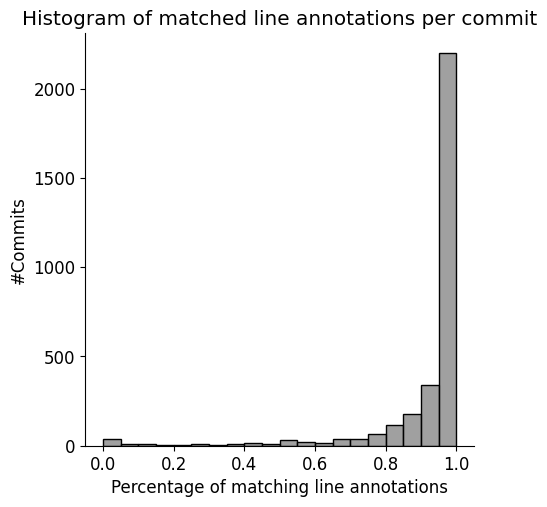

In [139]:
sns.displot(by_commit_eq_df['ratio'], rug=False, bins=20, kde=False, color='grey')

ax = plt.gca()
ax.set_title('Histogram of matched line annotations per commit')
ax.set_xlabel('Percentage of matching line annotations')
ax.set_ylabel('#Commits')
#ax.set_xlim(0,1)

plt.show()

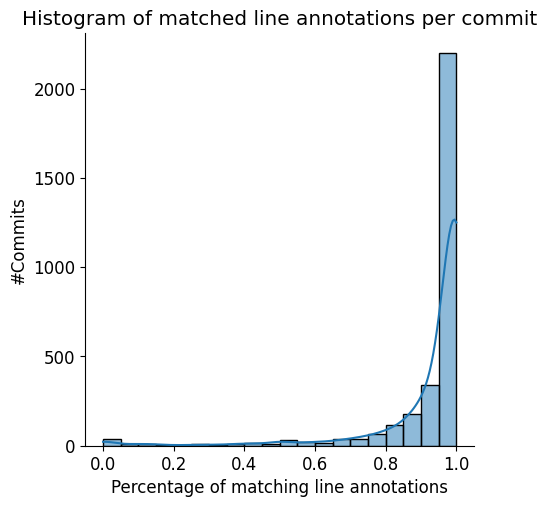

In [140]:
sns.displot(by_commit_eq_df['ratio'], rug=False, bins=20, kde=True)

ax = plt.gca()
ax.set_title('Histogram of matched line annotations per commit')
ax.set_xlabel('Percentage of matching line annotations')
ax.set_ylabel('#Commits')
#ax.set_xlim(0,1)

plt.show()

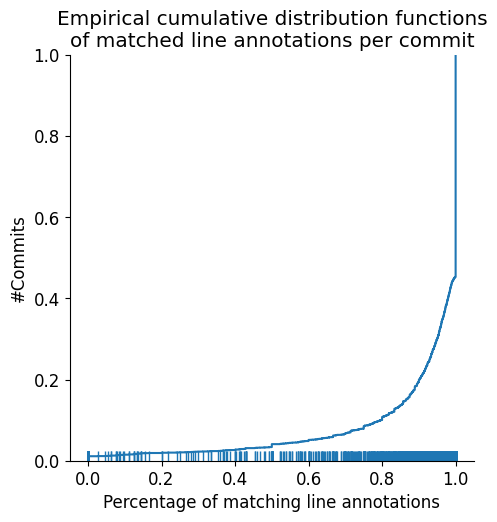

In [141]:
sns.displot(by_commit_eq_df['ratio'], rug=True, kind="ecdf")

ax = plt.gca()
ax.set_title('Empirical cumulative distribution functions\nof matched line annotations per commit')
ax.set_xlabel('Percentage of matching line annotations')
ax.set_ylabel('#Commits')
#ax.set_xlim(0,1)

plt.show()

<Axes: xlabel='ratio'>

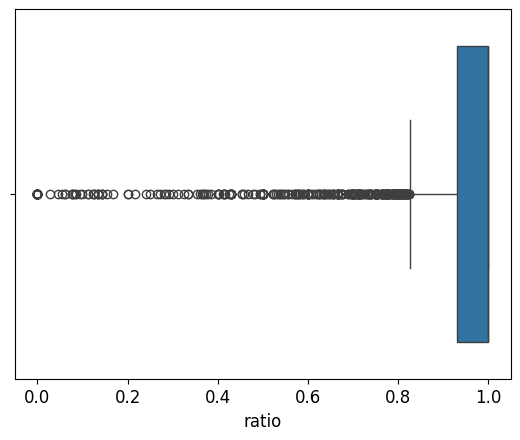

In [142]:
sns.boxplot(x=by_commit_eq_df['ratio'])

<Axes: xlabel='ratio'>

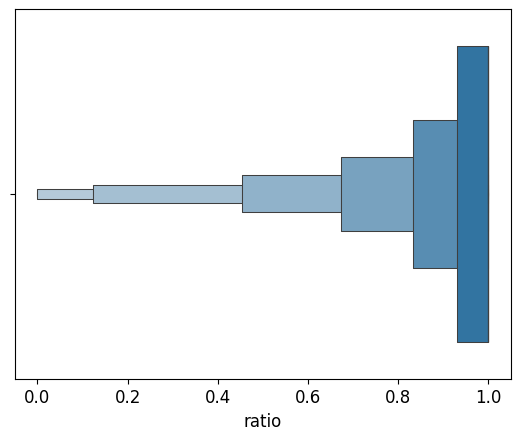

In [143]:
sns.boxenplot(x=by_commit_eq_df['ratio'])

In [144]:
by_commit_eq_df['ratio'].describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99,0.999,0.9999,0.99999])

count      3153.000000
mean          0.925410
std           0.167948
min           0.000000
25%           0.929825
50%           1.000000
75%           1.000000
90%           1.000000
95%           1.000000
99%           1.000000
99.9%         1.000000
99.99%        1.000000
99.999%       1.000000
max           1.000000
Name: ratio, dtype: float64

In [145]:
by_commit_eq_df['ratio'].describe(percentiles=[0.01,0.05,0.1,0.2,0.25,0.3,0.4,0.5,0.75])

count    3153.000000
mean        0.925410
std         0.167948
min         0.000000
1%          0.000000
5%          0.600000
10%         0.797388
20%         0.901408
25%         0.929825
30%         0.950000
40%         0.979338
50%         1.000000
75%         1.000000
max         1.000000
Name: ratio, dtype: float64

In [146]:
from scipy.stats import bootstrap

In [147]:
by_commit_eq_ratio_data = by_commit_eq_df['ratio'].values
by_commit_eq_ratio_data

array([0.11111111, 0.77272727, 1.        , ..., 0.83333333, 1.        ,
       0.78571429])

In [148]:
rng = np.random.default_rng()

res.standard_error=np.float64(0.006101590221833957)
ConfidenceInterval(low=np.float64(0.15814645912895386), high=np.float64(0.17819033287300207))


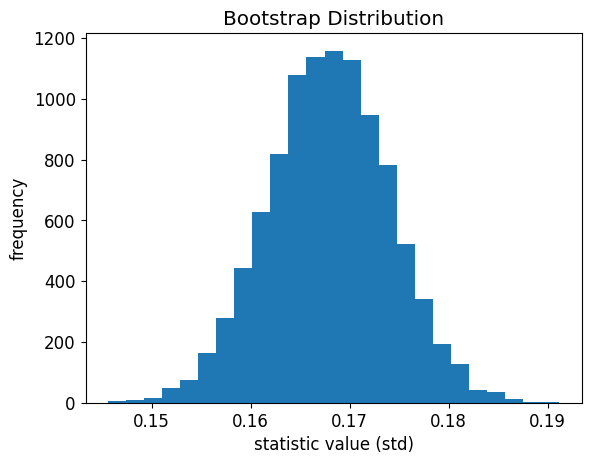

In [149]:
res = bootstrap((by_commit_eq_ratio_data,), np.std, confidence_level=0.9,
                random_state=rng)
fig, ax = plt.subplots()
ax.hist(res.bootstrap_distribution, bins=25)
ax.set_title('Bootstrap Distribution')
ax.set_xlabel('statistic value (std)')
ax.set_ylabel('frequency')

print(f"{res.standard_error=}")
print(res.confidence_interval)
plt.show()

res.standard_error=np.float64(0.0030389531989620327)
ConfidenceInterval(low=np.float64(0.9202660119001642), high=np.float64(0.9302888934296732))
by_commit_eq_df['ratio'].mean()=np.float64(0.9254102422058237)
by_commit_eq_df['ratio'].std()=np.float64(0.16794768506468252)


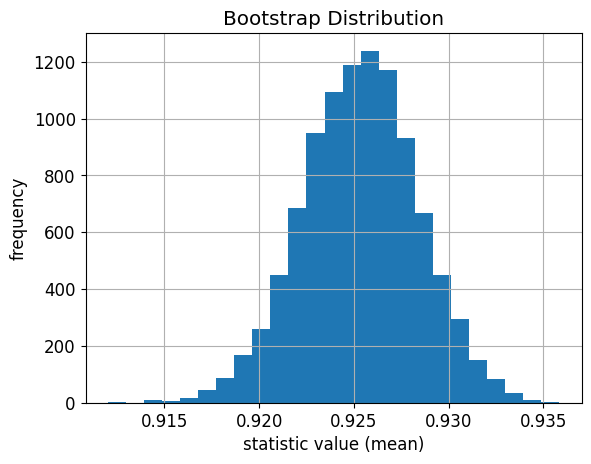

In [152]:
res = bootstrap((by_commit_eq_ratio_data,), np.mean, confidence_level=0.9,
                random_state=rng)
fig, ax = plt.subplots()
ax.hist(res.bootstrap_distribution, bins=25)
ax.set_title('Bootstrap Distribution')
ax.set_xlabel('statistic value (mean)')
ax.set_ylabel('frequency')
ax.grid()

print(f"{res.standard_error=}")
print(res.confidence_interval)
print(f"{by_commit_eq_df['ratio'].mean()=}")
print(f"{by_commit_eq_df['ratio'].std()=}")
plt.show()

res.standard_error=np.float64(0.0)
ConfidenceInterval(low=np.float64(nan), high=np.float64(nan))


/home/jnareb/python-diff-annotator/.venv/lib/python3.12/site-packages/scipy/stats/_resampling.py:149: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/tmp/ipykernel_3965774/2321583984.py:1: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  res = bootstrap((by_commit_eq_ratio_data,), np.median,


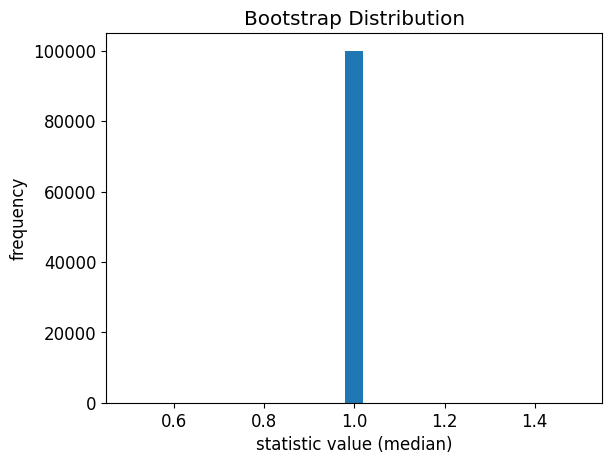

In [151]:
res = bootstrap((by_commit_eq_ratio_data,), np.median,
                confidence_level=0.9, n_resamples=99999,
                random_state=rng)
fig, ax = plt.subplots()
ax.hist(res.bootstrap_distribution, bins=25)
ax.set_title('Bootstrap Distribution')
ax.set_xlabel('statistic value (median)')
ax.set_ylabel('frequency')

print(f"{res.standard_error=}")
print(res.confidence_interval)
plt.show()